# Pb scavenging parameterization

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Parameters / settings:

In [188]:
land_color = '#a9a7a2'

# Domain dimensions:
imin, imax = 159, 799
jmin, jmax = 1099, 2179

General files:

In [189]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [190]:
# BLING:

folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
folder_EPM102 = '/data/brogalla/ANHA4/BLING-EPM102/'

dset = xr.open_dataset(f'{folder_EPM101}ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons = dset['nav_lon'].values
ANHA4_lats = dset['nav_lat'].values
ANHA4_depths = dset['deptht'].values

file_range = ['ANHA4-EPM101_y2002m08d18_gridB.nc', 'ANHA4-EPM101_y2002m08d23_gridB.nc', 'ANHA4-EPM101_y2002m08d28_gridB.nc', \
              'ANHA4-EPM101_y2002m09d02_gridB.nc', 'ANHA4-EPM101_y2002m09d07_gridB.nc', 'ANHA4-EPM101_y2002m09d12_gridB.nc', \
              'ANHA4-EPM101_y2002m09d17_gridB.nc', 'ANHA4-EPM101_y2002m09d22_gridB.nc', 'ANHA4-EPM101_y2002m09d27_gridB.nc', \
              'ANHA4-EPM101_y2002m10d02_gridB.nc', 'ANHA4-EPM101_y2002m10d07_gridB.nc']

biomass_p = np.zeros((50,800,544))
zflux_pop = np.zeros((50,800,544))
for n,file in enumerate(file_range):
    dset = xr.open_dataset(folder_EPM101+file)
    biomass_p = biomass_p + dset['biomass_p'][0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    zflux_pop = zflux_pop + dset['jp_pop'] [0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    
biomass = biomass_p / n
zflux   = zflux_pop / n 

In [191]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2015_20211012/ANHA12_EXH006_2015_monthly.nc')
# dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/old/Mn-reference-202101/ref-2015-202101/ANHA12_EXH006_2015_monthly.nc')
ANHA12_lons = dset_ANHA12['nav_lon'].values
ANHA12_lats = dset_ANHA12['nav_lat'].values
ANHA12_Mn   = dset_ANHA12['dissolmn'][8,0,:,:,:].values
ANHA12_Mn[ANHA12_Mn < 0] = 0

Functions:

In [192]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    
    LatLonPair = (nav_lon, nav_lat)
    var_out = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='linear')
    var_out[np.isnan(var_out)] = 0.0 # if that is still NaN, then set to zero.
    return var_out

In [193]:
def find_index_ANHA12(lons, lats, ANHA12_lon=ANHA12_lons, ANHA12_lat=ANHA12_lats):
    # input:   ANHA12_lons, ANHA12_lats     --- 700x640 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values
    # output:  i, j                         --- lists of coordinates associated with these points
    
    all_i = np.array([])
    all_j = np.array([])
    if isinstance(lons,float):
        i, j = ar.find_closest_model_point(lons, lats, ANHA12_lon, ANHA12_lat)
        all_i = i
        all_j = j
    else:
        for k in range(0,len(lons)):
            i, j = ar.find_closest_model_point(lons[k], lats[k], ANHA12_lon, ANHA12_lat)
            all_i = np.append(all_i, i)
            all_j = np.append(all_j, j)
    
    return all_i, all_j

In [194]:
def plot_residence_time(res_time, depth_slice=(0,18), maxv=1.0):
    res_time_slice = np.mean(res_time[depth_slice[0]:depth_slice[1],:,:], axis=0)
    
    fig, ax1 = plt.subplots(1,1,figsize=(4.5, 3.74), dpi=300)

    proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
    proj.drawcoastlines(color='#373736', linewidth=1.0);
    proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    
    x, y = proj(mesh_lon, mesh_lat)
    proj.contourf(x, y, bathy_masked[depth_slice[1],:,:], colors=[land_color]) # Mask land at particular depth
    
    # Domain boundaries: 
    proj.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c='k', lw=1.0, zorder=5); # southeastern Greenland
    proj.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c='k', lw=1.0, zorder=5); # southern Baffin Bay
    proj.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c='k', lw=1.0, zorder=5); # western Canada Basin
    proj.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c='k', lw=1.0, zorder=5); # northern Canada Basin
    proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c='k', lw=1.0, zorder=5); # Hudson Bay bdy
    
    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if depth_slice[0] < 17:
        x_kadko, y_kadko = proj(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj(chen_lons, chen_lats)
        CB = proj.scatter(x_kadko, y_kadko, c=kadko_res, s=30, edgecolor='w', zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        proj.scatter(x_chen, y_chen, c=chen_res, s=30, edgecolor='w', zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        
        cbaxes1 = fig.add_axes([0.13, 0.17, 0.03, 0.23]) 
        CBar1 = plt.colorbar(CB, ax=ax1, cax=cbaxes1, orientation='vertical')
        CBar1.ax.tick_params(labelsize=6) 
        CBar1.set_label('Residence time [years]', fontsize=6)
        
    # Model residence time estimate:
    x_ANHA12, y_ANHA12 = proj(ANHA12_lons, ANHA12_lats)
    CB2 = proj.contourf(x_ANHA12, y_ANHA12, res_time_slice, levels=np.linspace(0,maxv,21), cmap=cmocean.cm.matter, vmin=0, vmax=maxv, extend='both')
        
    # Colorbar:
    cbaxes2 = fig.add_axes([0.25, 0.17, 0.03, 0.23]) 
    CBar2 = plt.colorbar(CB2, ax=ax1, cax=cbaxes2, orientation='vertical')
    CBar2.ax.tick_params(labelsize=6) 
    CBar2.set_label('Model residence time', fontsize=6)
    
    ax1.set_title(f'Depth slice: {depths[depth_slice[0]]:.0f}-{depths[depth_slice[1]]:.0f} m', fontsize=6)
    return

### Residence time estimates

Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp

In [195]:
# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

In [196]:
# Chen et al., 2012: 
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depths = np.array([30, 40, 10, 30, 40, 20, 30, 100])
chen_res    = np.array([0.05, 0.10, 0.01, 0.15, 0.03, 0.10, 0.23, 0.28])

In [197]:
kadko_ANHA12_i, kadko_ANHA12_j = find_index_ANHA12(kadko_lons, kadko_lats)
chen_ANHA12_i,  chen_ANHA12_j  = find_index_ANHA12(chen_lons, chen_lats)

### Particle estimates:

In [51]:
ANHA12_biomass = np.empty((50,700,640))
for depth in range(0,50):
    ANHA12_biomass[depth,:,:] = interp_np(ANHA4_lons.flatten(), ANHA4_lats.flatten(), biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)

In [198]:
# particles:
normalized_biogenic   = ANHA12_biomass/np.amax(ANHA12_biomass)
normalized_lithogenic = ANHA12_Mn/np.amax(ANHA12_Mn)

particle composition recipe: 
- $\beta$ --- lithogenic fraction
- $1-\beta$ --- biogenic fraction

In [168]:
betas     = np.linspace(0,1,40)
constants = np.linspace(1e-5,4e-2,20)
kadko_res_time_diff     = np.empty((len(kadko_res),len(constants),len(betas))); kadko_res_time_diff[:]     = np.nan;
kadko_modelled_res_time = np.empty((len(kadko_res),len(constants),len(betas))); kadko_modelled_res_time[:] = np.nan;
chen_res_time_diff      = np.empty((len(chen_res),len(constants),len(betas)));  chen_res_time_diff[:]      = np.nan;
chen_modelled_res_time  = np.empty((len(chen_res),len(constants),len(betas)));  chen_modelled_res_time[:]  = np.nan;

for ci,c in enumerate(constants):
    for bi, beta in enumerate(betas):
        # Residence time associated with these fractions
        res_time = c / ((1-beta)*normalized_biogenic + beta*normalized_lithogenic)

        # Difference between modeled and observed residence time at the stations:
        for n, stn in enumerate(zip(kadko_ANHA12_i, kadko_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                kadko_modelled_res_time[n,ci,bi] = np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
                kadko_res_time_diff[n,ci,bi]     = kadko_res[n] - np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
        
        
        for n, stn in enumerate(zip(chen_ANHA12_i, chen_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                chen_modelled_res_time[n,ci,bi] = np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
                chen_res_time_diff[n,ci,bi]     = chen_res[n] - np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m

In [169]:
kadko_res_time_diff_mean = np.nanmean(kadko_res_time_diff, axis=0)
kadko_res_time_rms       = np.sum(kadko_res_time_diff**2, axis=0)/len(kadko_res)

chen_res_time_diff_mean = np.nanmean(chen_res_time_diff, axis=0)
chen_res_time_rms       = np.sum(chen_res_time_diff**2, axis=0)/len(chen_res)

# Plots

Mean simulated biomass during period of sampling is normalized (biogenic particles) and combined with normalized Mn model field (lithogenic particles) as a measure of particle abundance. Then the particle abundance is inversely related to the residence time. Free parameters are: constant of inverse proportionality, fraction biogenic vs. lithogenic.

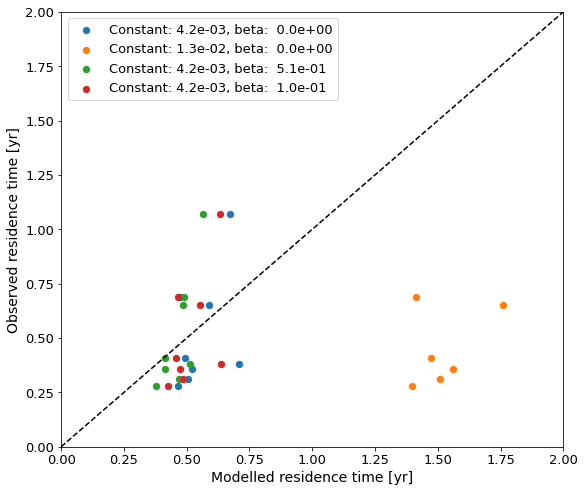

In [170]:
fig, ax = plt.subplots(1,1, figsize=(9,8))

ax.scatter(kadko_modelled_res_time[:,2,0], kadko_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(kadko_modelled_res_time[:,6,0], kadko_res, s=40, label=f'Constant: {constants[6]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(kadko_modelled_res_time[:,2,20], kadko_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[20]:.1e}')
ax.scatter(kadko_modelled_res_time[:,2,4], kadko_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[4]:.1e}')

ax.plot([0,2],[0,2], '--k')
ax.set_xlabel('Modelled residence time [yr]', fontsize=14)
ax.set_ylabel('Observed residence time [yr]', fontsize=14)
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.tick_params(labelsize=13)
ax.legend(fontsize=13)

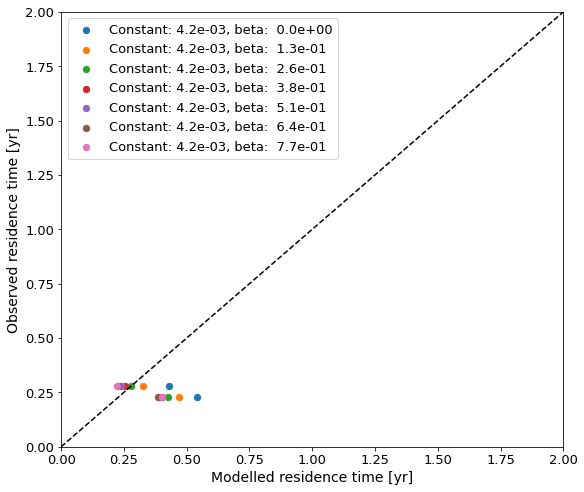

In [171]:
fig, ax = plt.subplots(1,1, figsize=(9,8))

ax.scatter(chen_modelled_res_time[:,2,0], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,5], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[5]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,10], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[10]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,15], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[15]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,20], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[20]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,25], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[25]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,30], chen_res, s=40, label=f'Constant: {constants[2]:.1e}, beta:  {betas[30]:.1e}')

ax.plot([0,2],[0,2], '--k')
ax.set_xlabel('Modelled residence time [yr]', fontsize=14)
ax.set_ylabel('Observed residence time [yr]', fontsize=14)
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.tick_params(labelsize=13)
ax.legend(fontsize=13)

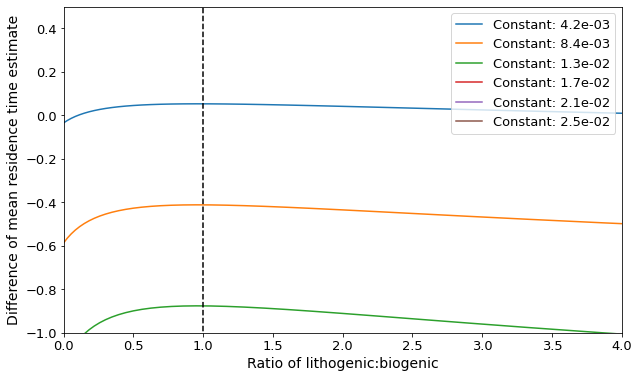

In [172]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(betas/(1-betas), kadko_res_time_diff_mean[2,:],'-', label=f'Constant: {constants[2]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[4,:],'-', label=f'Constant: {constants[4]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[6,:],'-', label=f'Constant: {constants[6]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[8,:],'-', label=f'Constant: {constants[8]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[10,:],'-', label=f'Constant: {constants[10]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[12,:],'-', label=f'Constant: {constants[12]:.1e}')
ax.plot([1,1],[-2,2], '--k')
ax.set_xlabel('Ratio of lithogenic:biogenic', fontsize=14)
ax.set_ylabel('Difference of mean residence time estimate', fontsize=14)
ax.set_xlim(0,4)
ax.set_ylim(-1,0.5)
ax.tick_params(labelsize=13)
ax.legend(fontsize=13)

In [173]:
cif, bif = np.meshgrid(constants, betas/(1-betas))

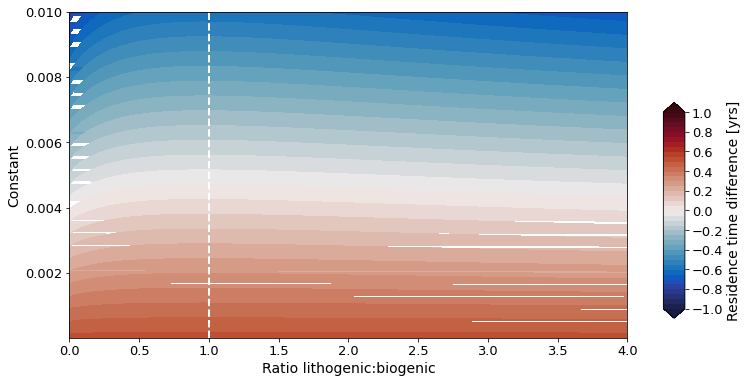

In [174]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

CB = ax.contourf(bif, cif, kadko_res_time_diff_mean.transpose(), \
                 levels=np.linspace(-1,1,41), cmap = cmocean.cm.balance, vmin=-1, vmax=1, extend='both')
ax.plot([1,1],[0,10],'--w', linewidth=2.0)
ax.set_xlabel('Ratio lithogenic:biogenic', fontsize=14)
ax.set_ylabel('Constant', fontsize=14)
ax.set_xlim(0,4)
ax.set_ylim(1e-5,1e-2)

# Colorbar:
ax.tick_params(labelsize=13)
cbaxes = fig.add_axes([0.95, 0.17, 0.03, 0.50]) 
CBar = plt.colorbar(CB, ax=ax, cax=cbaxes, orientation='vertical', ticks=np.arange(-1,1.2,0.2))
CBar.ax.tick_params(labelsize=13) 
CBar.set_label('Residence time difference [yrs]', fontsize=14)

In [175]:
lithogenic_fraction = beta
biogenic_fraction   = 1-beta

lif, bif = np.meshgrid(lithogenic_fraction, biogenic_fraction)

In [94]:
# # hold constant = 1e-2 while varying the lithogenic and biogenic fraction. Sum of lithogenic and biogenic fraction will always = 2.

# fig, ax = plt.subplots(1,1, figsize=(10,6))

# # color = deviation of residence time from observed values
# # CB = ax.scatter(lif, bif, c=res_time_diff_mean, cmap = cmocean.cm.amp, vmin=0.4, vmax=0.6)
# CB = ax.contourf(lif, bif, kadko_res_time_diff_mean.transpose(), levels=50, cmap = cmocean.cm.balance)#, vmin=-2.5, vmax=-1.5)
# ax.plot([0,10],[0,10],'--w', linewidth=2.0)
# ax.set_xlabel('Fraction biogenic', fontsize=14)
# ax.set_ylabel('Fraction lithogenic', fontsize=14)
# ax.set_xlim(0,10)
# ax.set_ylim(0,10)

# # Colorbar:
# ax.tick_params(labelsize=13)
# cbaxes = fig.add_axes([0.95, 0.17, 0.03, 0.50]) 
# CBar = plt.colorbar(CB, ax=ax, cax=cbaxes, orientation='vertical')
# CBar.ax.tick_params(labelsize=13) 
# CBar.set_label('Residence time difference [yrs]', fontsize=14)

In [186]:
print(np.mean(normalized_lithogenic,axis=(1,2)))
print(np.mean(normalized_biogenic,axis=(1,2)))

[1.31948628e-02 1.31932516e-02 1.31878946e-02 1.31741203e-02
 1.31408265e-02 1.30753592e-02 1.29373204e-02 1.26007441e-02
 1.05447499e-02 9.29006375e-03 7.53652956e-03 6.22731354e-03
 5.28721325e-03 4.64630732e-03 4.13554488e-03 3.73228779e-03
 3.38484417e-03 3.07170791e-03 2.79133813e-03 2.54672044e-03
 2.25615618e-03 1.90124591e-03 1.56207883e-03 1.34878443e-03
 1.08524796e-03 8.72309261e-04 7.02523219e-04 5.83165849e-04
 4.97468747e-04 4.29917418e-04 3.41490202e-04 2.73979618e-04
 2.23537441e-04 1.82035001e-04 1.53159213e-04 1.25534119e-04
 9.92207788e-05 7.72545682e-05 6.10017851e-05 4.72015745e-05
 3.38210193e-05 2.27183955e-05 1.54052887e-05 7.83376800e-06
 1.41142380e-06 4.07046592e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[5.81751196e-02 5.82942132e-02 5.85897264e-02 5.91222853e-02
 6.00097658e-02 6.14430983e-02 6.37074620e-02 6.71782925e-02
 3.55868757e-02 2.60001200e-02 2.10279871e-02 1.65389570e-02
 1.25017012e-02 9.12937093e-03 6.67134174e-03 2.28077

In [200]:
print(np.mean(normalized_lithogenic,axis=(1,2)))

[4.3492034e-02 4.3483596e-02 4.3468218e-02 4.3433573e-02 4.3354813e-02
 4.3192621e-02 4.2832404e-02 4.1910641e-02 3.5823837e-02 3.2412440e-02
 2.8561087e-02 2.4576558e-02 2.0803342e-02 1.7473362e-02 1.4610491e-02
 1.2241538e-02 1.0142792e-02 8.1445118e-03 5.3393305e-03 4.1639013e-03
 3.5940094e-03 3.7643590e-03 3.9733546e-03 4.3606362e-03 4.2788396e-03
 4.0204930e-03 3.8176377e-03 3.8025316e-03 3.7153985e-03 3.5769402e-03
 3.0953512e-03 2.6898675e-03 2.4081911e-03 2.1539954e-03 1.9357279e-03
 1.7156528e-03 1.5350013e-03 1.3765264e-03 1.2645639e-03 1.1384127e-03
 9.5228537e-04 6.9513463e-04 4.4535229e-04 2.5806806e-04 1.3307715e-04
 9.2889923e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [176]:
# composition recipe:
beta     = 0.51
particles = (1-beta)*normalized_biogenic + beta*normalized_lithogenic

# residence times:
constant  = 4e-3 #8e-3 #4e-3
modelled_res_time = constant / particles

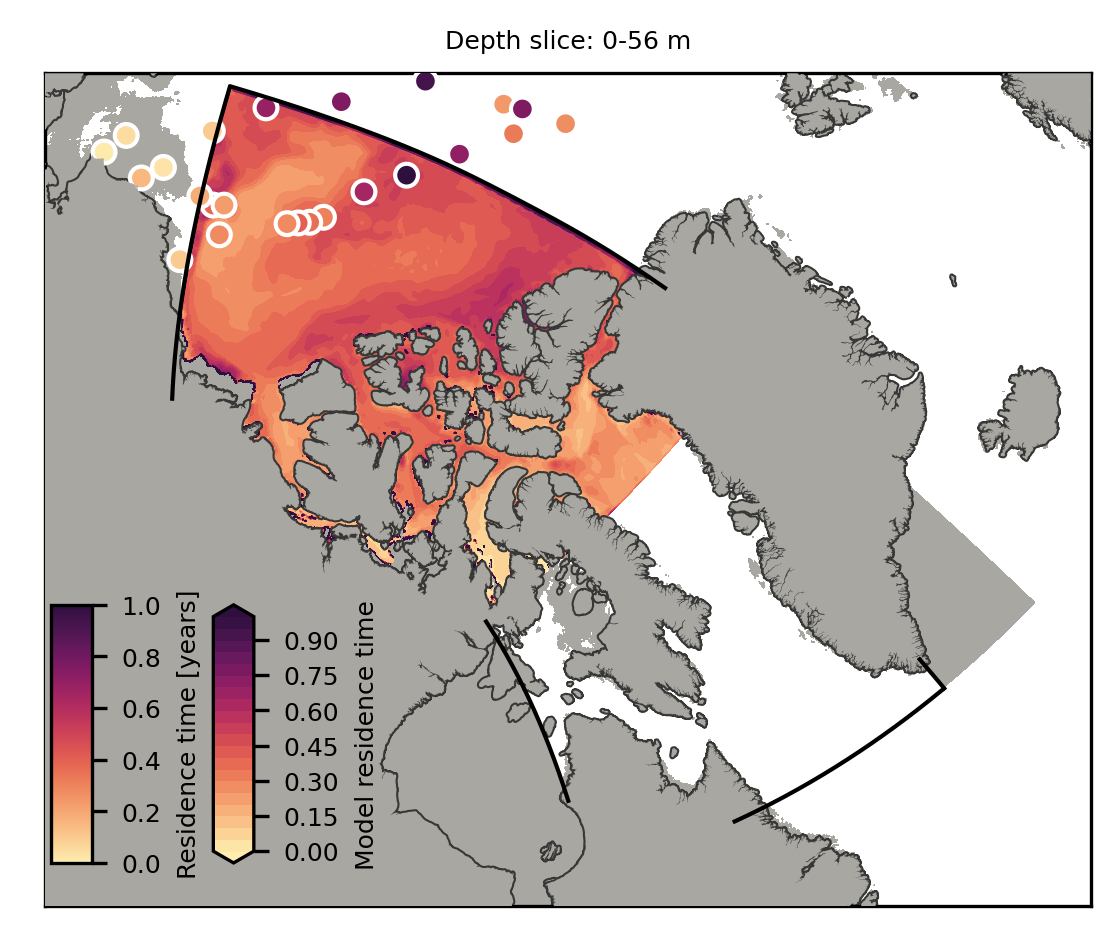

In [177]:
plot_residence_time(modelled_res_time, depth_slice=(0,18), maxv=1)

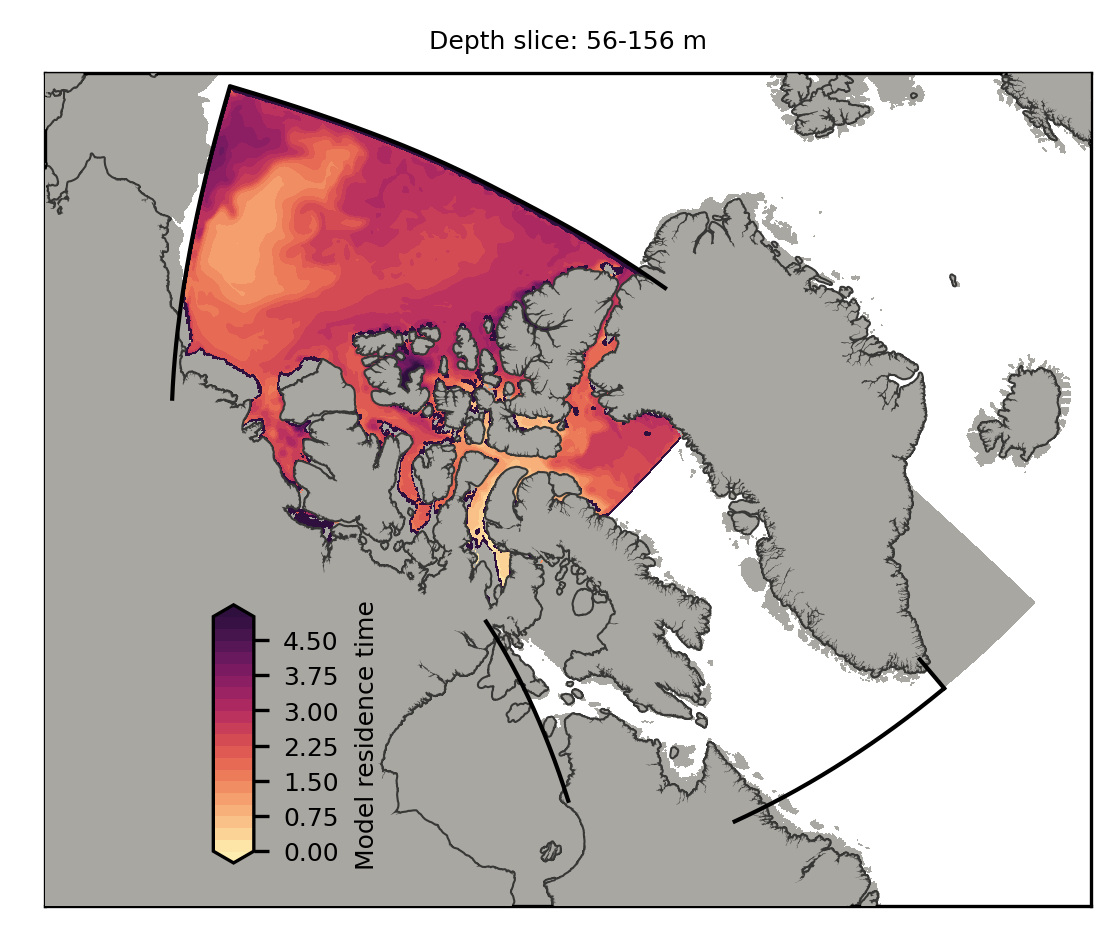

In [178]:
plot_residence_time(modelled_res_time, depth_slice=(18,24), maxv=5)

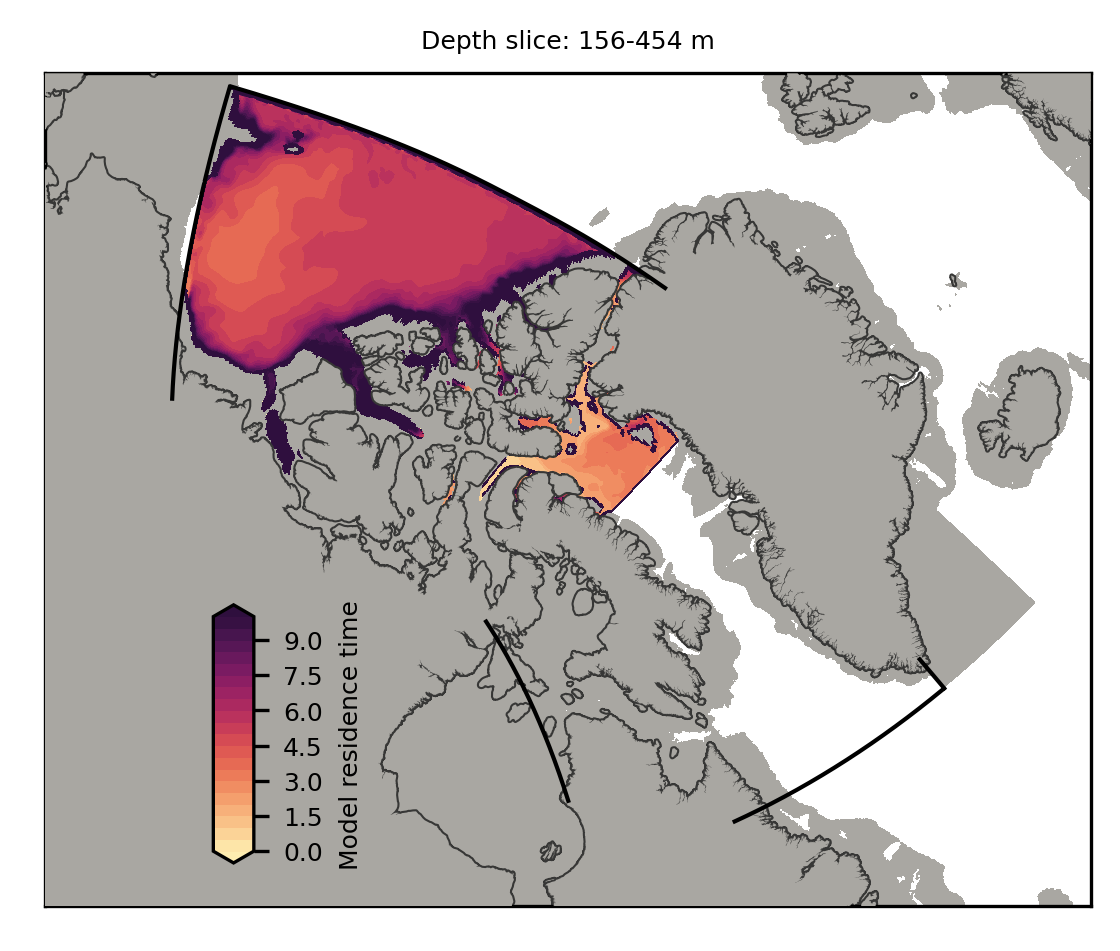

In [179]:
plot_residence_time(modelled_res_time, depth_slice=(24,30), maxv=10)

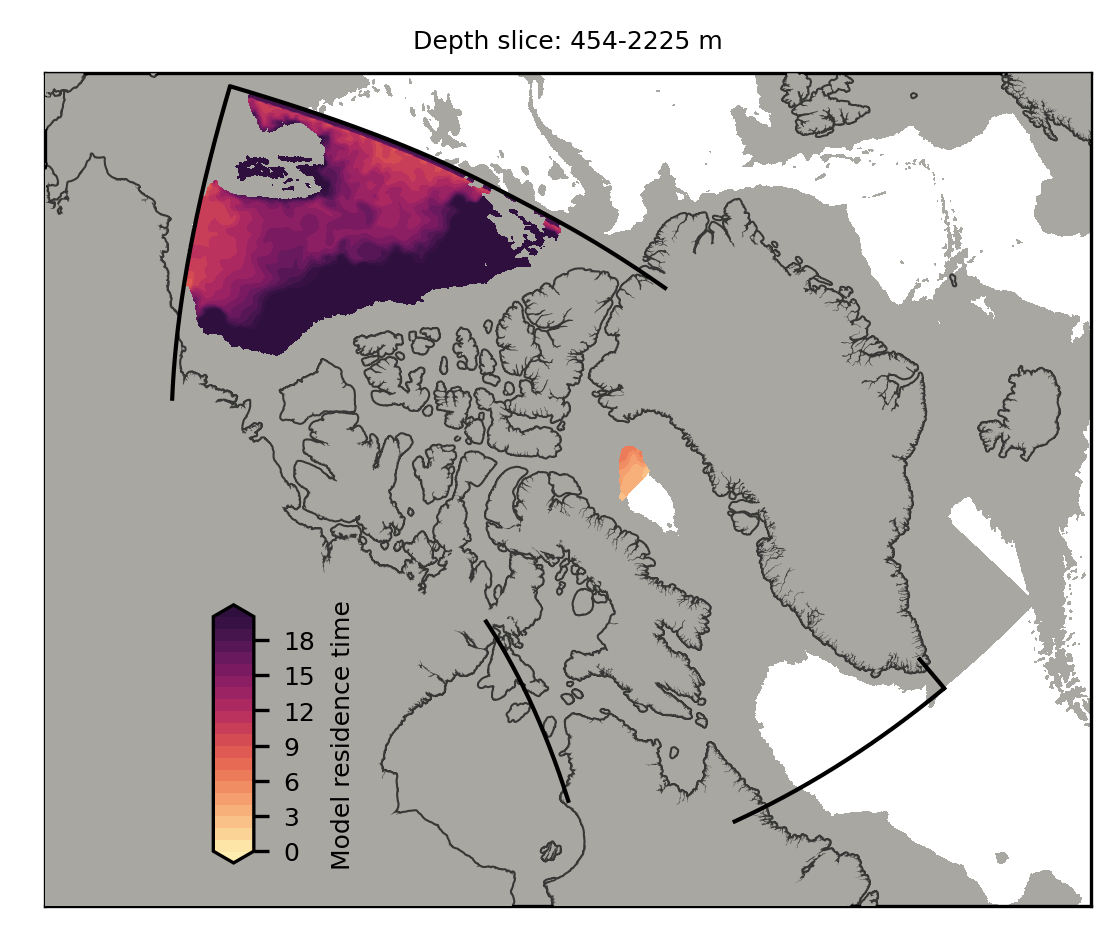

In [180]:
plot_residence_time(modelled_res_time, depth_slice=(30,40), maxv=20)

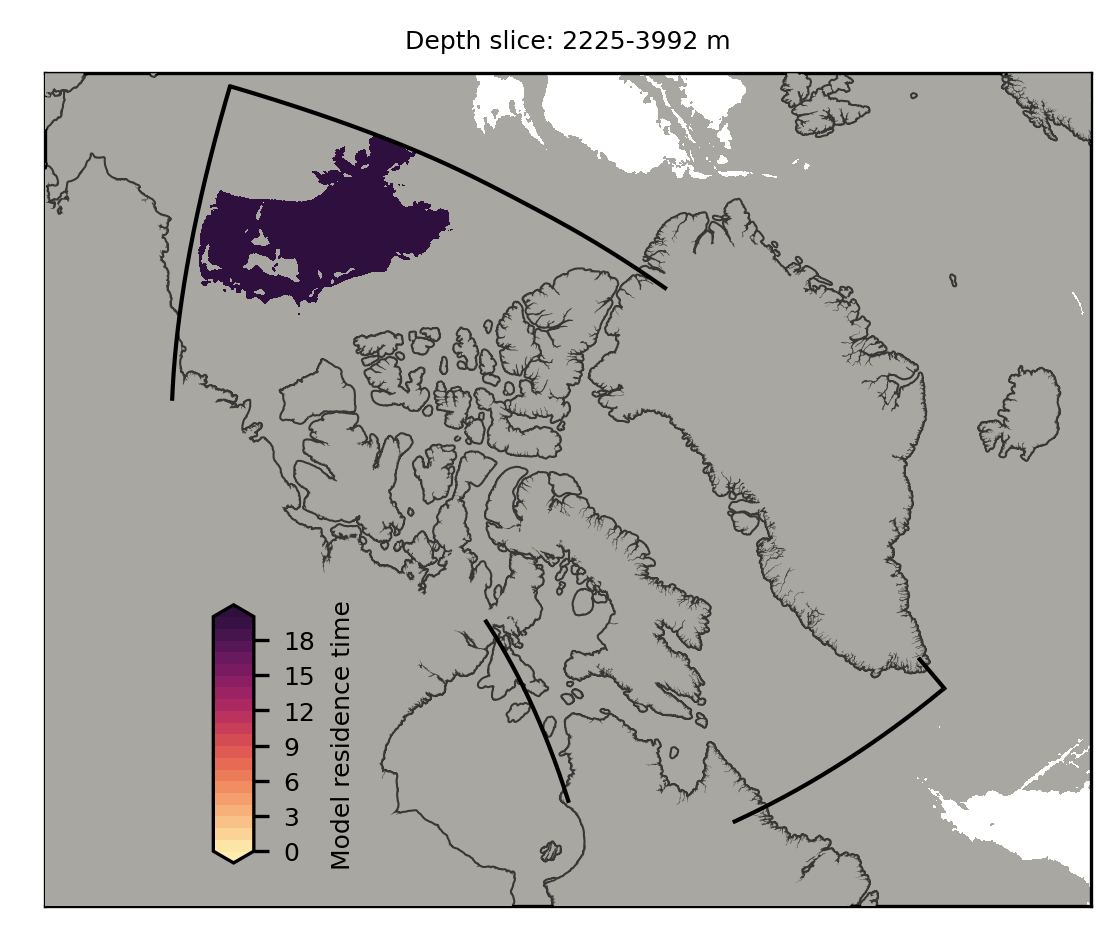

In [181]:
plot_residence_time(res_time, depth_slice=(40,45), maxv=20)